# Biosignal Analytics Project - Group 4
## EEG Sleep Stage Detection
### Andrei Ivanov (andiva@utu.fi) | Faiza Noor (fanoor@utu.fi)

In [64]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import scipy as sp
import os
import antropy as ant
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [65]:
# importing data

train_path = os.path.join(os.getcwd(), "Data", "Train")
test_path = os.path.join(os.getcwd(), "Data", "Test")

train_x = []
train_y = []
test_x = []
test_y = []

#train classes
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    train_y.append([folder]*len(os.listdir(folder_path)))
    
train_y = [item for sublist in train_y for item in sublist]

#test classes
for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    test_y.append([folder]*len(os.listdir(folder_path)))
    
test_y = [item for sublist in test_y for item in sublist]

# train data
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        train_x.append(np.loadtxt(file_path, delimiter=',', skiprows=1))

# test data
for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        test_x.append(np.loadtxt(file_path, delimiter=',', skiprows=1))

### Query example for data ###
<p> train_x[0][:,0] - Fpz-Cz channel for the 1st csv read
<p> train_x[2][:,1] - Pz-Oz channel for the 3rd csv read
<p> classes in the y arrays as well as data arrays are read in the order found in folders so matrix train_x[5] will have its corresponding class train_y[5]

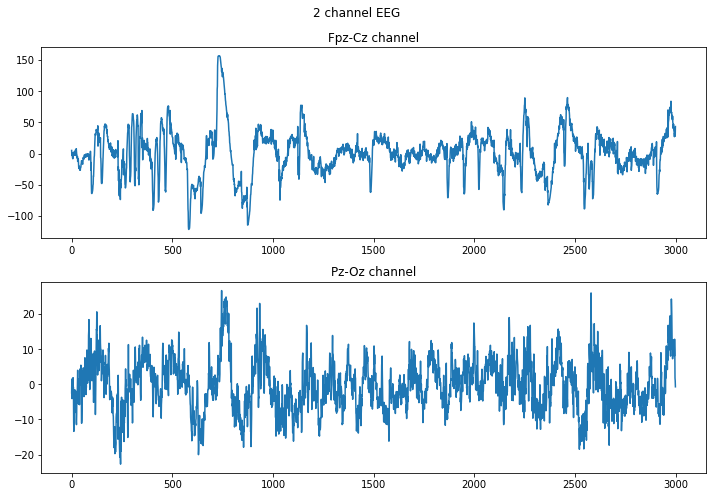

In [66]:
# plot test
plt.figure(figsize=(10,7))
plt.suptitle("2 channel EEG")
plt.subplot(2,1,1)
plt.plot(train_x[0][:,0])
plt.title("Fpz-Cz channel")
plt.subplot(2,1,2)
plt.plot(train_x[0][:,1])
plt.title("Pz-Oz channel")
plt.tight_layout()

## Feature extraction functions
### Time-domain features to be extracted:
<ul>
    <li> Root-Mean-Square </li>
    <li> Zero-Crossing-Rate </li>
    <li> Mean, Standard Deviation, Variance, Skewness, Kurtosis </li>
</ul>

### Frequency domain features:

<ul>
    <li> low delta (0.5-1 Hz), delta (1-4 Hz) , theta (4-8 Hz), alpha (8-12 Hz), sigma (12-15 Hz), and beta (15-30 Hz) bands relative power </li>
    <li> Spectral Entropy, Katz Fractal Dimension </li>
    <li> Spectral Edge Frequency </li>
    <li> inter-channel Itakura Distance (procedures from https://raphaelvallat.com/bandpower.html, https://rug.mnhn.fr/seewave/HTML/MAN/itakura.dist.html) </li>
</ul>

In [72]:
# Extract time-domain features

def time_dom_features(signal):
    rms = np.sqrt(np.mean(np.square(signal)))
    zcr = np.mean(np.abs(np.diff(np.sign(signal))))
    # summary statistics
    mean = np.mean(signal)
    std = np.std(signal)
    var = np.var(signal)
    skewness = sp.stats.skew(signal)
    kurtosis2 = sp.stats.kurtosis(signal)
    return rms, zcr, mean, std, var, skewness, kurtosis2

def FFT_prepare (eeg, Fs, cutoff_high, cutoff_low):
# function that does the FFT on the EEG signal and applies a true digital bandpass filter to it
# we mostly need it for removing the DC component on 0Hz as the FFT will only contain frequency
# components up to 50Hz which is the Nyquist frequency for a signal sampled at 100Hz
# but the function is more general and could be applied on signals with higher sampling frequency
    fft = np.fft.fft(eeg)
    fftfreq = np.fft.fftfreq(len(eeg), 1/Fs)
    for i, freq in enumerate(fftfreq):
        if abs(freq) >= cutoff_high or abs(freq) <= cutoff_low:
            fft[i] = 0
    return fft[:int(len(fft)/2)], fftfreq[:int(len(fft)/2)]

def extract_bands(fft, fftfreq):
    low_delta_lim_low = np.where(fftfreq == 0.5)[0][0]
    low_delta_lim_hi = np.where(fftfreq == 1)[0][0]
    delta_lim_hi = np.where(fftfreq == 4)[0][0]
    theta_lim_hi = np.where(fftfreq == 8)[0][0]
    alpha_lim_hi = np.where(fftfreq == 12)[0][0]
    sigma_lim_hi = np.where(fftfreq == 15)[0][0]
    beta_lim_hi = np.where(fftfreq == 30)[0][0] #higher limit of beta can be taken but in the
                                                #application where we look at sleep stages
                                                #beta waves are not that relevant
    low_delta = [fft[low_delta_lim_low:low_delta_lim_hi],fftfreq[low_delta_lim_low:low_delta_lim_hi]]
    delta = [fft[low_delta_lim_hi:delta_lim_hi],fftfreq[low_delta_lim_hi:delta_lim_hi]]
    theta = [fft[delta_lim_hi:theta_lim_hi],fftfreq[delta_lim_hi:theta_lim_hi]]
    alpha = [fft[theta_lim_hi:alpha_lim_hi],fftfreq[theta_lim_hi:alpha_lim_hi]]
    sigma = [fft[alpha_lim_hi:sigma_lim_hi],fftfreq[alpha_lim_hi:sigma_lim_hi]]
    beta = [fft[sigma_lim_hi:beta_lim_hi],fftfreq[sigma_lim_hi:beta_lim_hi]]
    return low_delta,delta,theta,alpha,sigma,beta

def relative_power(eeg_fft, low_delta, delta, theta, alpha, sigma, beta):
    total_pwr = np.sum(np.abs(eeg_fft)**2)
    low_delta_pwr = np.sum(np.abs(low_delta[0])**2)/total_pwr
    delta_pwr = np.sum(np.abs(delta[0])**2)/total_pwr
    theta_pwr = np.sum(np.abs(theta[0])**2)/total_pwr
    alpha_pwr = np.sum(np.abs(alpha[0])**2)/total_pwr
    sigma_pwr = np.sum(np.abs(sigma[0])**2)/total_pwr
    beta_pwr = np.sum(np.abs(beta[0])**2)/total_pwr
    return low_delta_pwr,delta_pwr,theta_pwr,alpha_pwr,sigma_pwr,beta_pwr

def itakura_dist_channels(fpzcz, pzoz, Fs):
    _, fpzcz_psd = sp.signal.welch(fpzcz, Fs)
    _, pzoz_psd = sp.signal.welch(pzoz, Fs) 
    ratio = np.divide(fpzcz_psd, np.maximum(pzoz_psd, np.finfo(float).eps)) #avoid division by 0
    log_ratio = np.log(ratio)
    itakura_dist = np.sum(ratio - log_ratio - 1)
    return itakura_dist
  
def extract_entropies(signal, Fs):
    spectral = ant.spectral_entropy(signal, sf=Fs, method='welch', normalize=True)
    katz = ant.katz_fd(signal)
    return spectral, katz

def spectral_edge_frequency(fft,fftfreq,percent):
    #percent is how much power on the left of the sought after frequency on spectrum
    total_pwr = np.sum(np.abs(fft)**2)
    target_power = total_pwr * percent
    idx = np.argmax(total_pwr >= target_power)
    return fftfreq[idx]

## Observations:
- The "filtering" can be viewed as a true digital filter because all the amplitudes are completely discarded for the unwanted frequencies instead of just attenuated.
- Multiple entropy features could be extracted using the library used in theory but we had trouble with making the functions work so we stuck with just those two measures.

### Visualizing example spectra for both channels

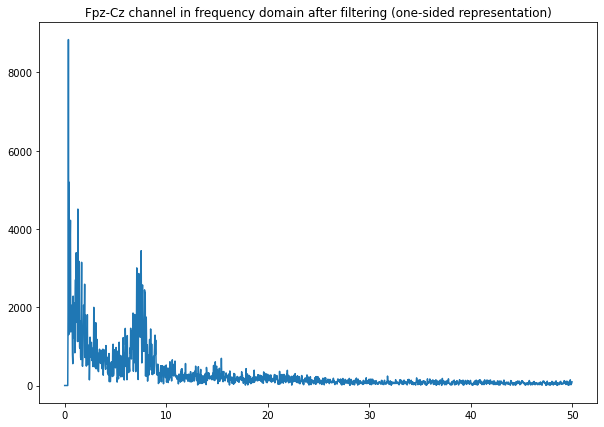

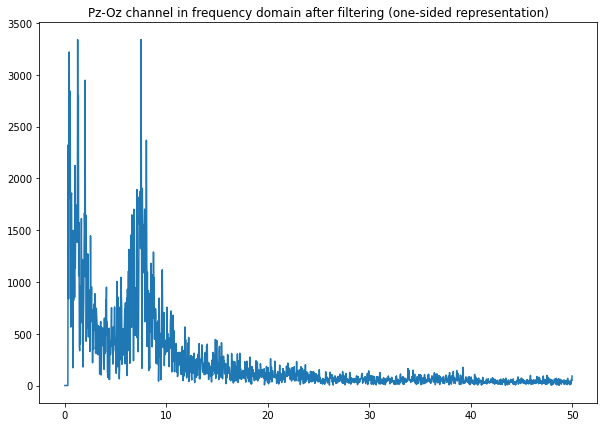

In [73]:
fpzcz, fpzcz_freq = FFT_prepare(train_x[1356][:,0], 100, 50, 0.3) 
pzoz, pzoz_freq = FFT_prepare(train_x[1356][:,1], 100, 50, 0.3) 
plt.figure(figsize=(10,7))
plt.plot(abs(fpzcz_freq),abs(fpzcz))
plt.title("Fpz-Cz channel in frequency domain after filtering (one-sided representation)")
plt.show()
plt.figure(figsize=(10,7))
plt.plot(abs(pzoz_freq),abs(pzoz))
plt.title("Pz-Oz channel in frequency domain after filtering (one-sided representation)")
plt.show()

## Observations:
There are clear differences observed between how the spectra appears between the provided channels for each sample, so feature extraction will happen to each channel.

## Building the final feature dataset

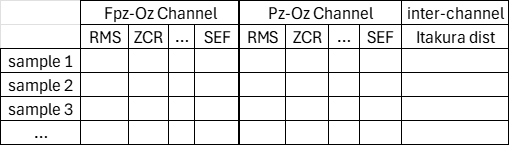

In [74]:
# combine feature extraction functions

# with function below features are computed separately for the Fpz-Cz and Pz-Oz channels
def single_channel_features(signal, Fs):
    rms, zcr, mean, std, var, skewness, kurtosis = time_dom_features(signal)

    fft, fftfreq = FFT_prepare(signal,Fs,50,0.5)
    low_delta,delta,theta,alpha,sigma,beta = extract_bands(fft,fftfreq)
    low_delta_pwr,delta_pwr,theta_pwr,alpha_pwr,sigma_pwr,beta_pwr = relative_power(fft,low_delta,delta,theta,alpha,sigma,beta)
    spectral, katz = extract_entropies(signal, Fs)
    sef = spectral_edge_frequency(fft,fftfreq,0.95) #percentage set at 95%

    return [rms, zcr, mean, std, var, skewness, kurtosis, low_delta_pwr,delta_pwr,theta_pwr,alpha_pwr,sigma_pwr,beta_pwr, spectral, katz, sef]

# itakura distance is the only inter-channel measure we computed so the function will be used as-is

# feature extraction logic: columns: 2 channels x 16 features + 1 inter-channel feature
#                           rows: EEG recording instances

train_features = np.zeros((len(train_x),33))
for i in range(0,len(train_x),1):
    train_features[i,0:16] = single_channel_features(train_x[i][:,0], 100) 
    train_features[i,16:32] = single_channel_features(train_x[i][:,1], 100)
    train_features[i,32] = itakura_dist_channels(train_x[i][:,0], train_x[i][:,1], 100)

test_features = np.zeros((len(test_x),33))
for i in range(0,len(test_x),1):
    test_features[i,0:16] = single_channel_features(test_x[i][:,0], 100)
    test_features[i,16:32] = single_channel_features(test_x[i][:,1], 100)
    test_features[i,32] = itakura_dist_channels(test_x[i][:,0], test_x[i][:,1], 100)

## Observations:
- In the piece of code above there are certain parameters that could be changed, such as the frequency limits for the signal filtering and the percentage used for computing the Spectral Edge Frequency.
- If the number of features extracted changes, the feature set "building" matrices and loops need to be slightly modified as the indices will modify.

## ML model building

We are using the <b> Random Forest Classifier </b> and the <b> Support Vector Machine Classifier </b>

Random Forest Classifier Performance Metrics

Overall accuracy: 0.806

               precision    recall  f1-score   support

       Awake       0.97      1.00      0.99       450
          N1       0.57      0.52      0.55       295
          N2       0.85      0.91      0.88       450
          N3       0.86      0.84      0.85       310
          N4       0.67      0.24      0.36        33
         REM       0.68      0.69      0.68       368

    accuracy                           0.81      1906
   macro avg       0.77      0.70      0.72      1906
weighted avg       0.80      0.81      0.80      1906



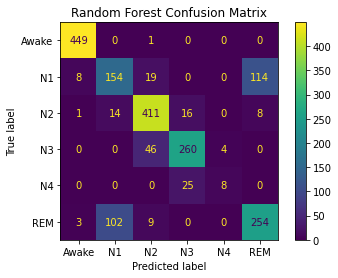

In [75]:
svc = skl.svm.SVC(C=100,gamma=0.001,kernel='rbf') # parameters chosen with GridSearchCV
rf = RandomForestClassifier()
scaler = skl.preprocessing.StandardScaler()

# Fit scaler on training features
scaler.fit(train_features)

# Fit models on normalized feature set
rf.fit(scaler.transform(train_features), train_y) 
svc.fit(scaler.transform(train_features), train_y)

# Use models to predict on test data normalized with scaler fit on train data
y_pred = rf.predict(scaler.transform(test_features))
accuracy = accuracy_score(test_y, y_pred)
cm = confusion_matrix(test_y, y_pred)

print("Random Forest Classifier Performance Metrics\n")
print("Overall accuracy:",'{:.3f}'.format(accuracy))
target_names = ['Awake', 'N1', 'N2', 'N3', 'N4', 'REM']
print('\n',classification_report(test_y, y_pred, target_names=target_names))
f, ax = plt.subplots()
ax.set_title("Random Forest Confusion Matrix")
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax)
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
plt.show()

SVC Performance Metrics

Overall accuracy: 0.812

               precision    recall  f1-score   support

       Awake       0.97      0.99      0.98       450
          N1       0.59      0.55      0.57       295
          N2       0.87      0.91      0.89       450
          N3       0.88      0.84      0.86       310
          N4       0.44      0.33      0.38        33
         REM       0.68      0.71      0.69       368

    accuracy                           0.81      1906
   macro avg       0.74      0.72      0.73      1906
weighted avg       0.81      0.81      0.81      1906



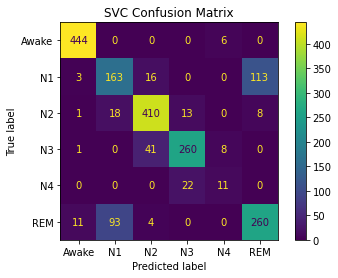

In [76]:
y_pred = svc.predict(scaler.transform(test_features))
accuracy = accuracy_score(test_y, y_pred)
cm = confusion_matrix(test_y, y_pred)

print("SVC Performance Metrics\n")
print("Overall accuracy:",'{:.3f}'.format(accuracy))
target_names = ['Awake', 'N1', 'N2', 'N3', 'N4', 'REM']
print('\n',classification_report(test_y, y_pred, target_names=target_names))
f, ax = plt.subplots()
ax.set_title("SVC Confusion Matrix")
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax)
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
plt.show()

## Metrics observations:
- On different runs, accuracy might be slightly different (0.80 - 0.82) for the Random Forrest Classifier because of the "randomness" that creating each decision tree involves, but the SVC value will remain constant at 0.812.
- It can be concluded that the models are able to distinguish between "Awake" and "People in any sleep state" but have troubles with distinguishing between different sleep stages.
- This can be because the support data that is used to train and test the models has disproportionate representation for different stages (N4 class a really small support).
- One conclusion can be that both classifiers perform similarly on this classification problem.